# Do Android Wolves Dream of Electric Sheep? 🐺🐑
## LLM-Driven Agent-Based Modeling of Predator-Prey Dynamics

This notebook provides an introduction to our research on integrating Large Language Models (LLMs) into continuous dynamical systems, specifically the Lotka-Volterra predator-prey equations.

### Research Overview

This project investigates whether LLM-based agents can successfully modulate continuous dynamical systems to achieve stable equilibria. We employ the well-characterized Lotka-Volterra system as a quantitative testbed, introducing a behavioral parameter θ (theta) that allows predator agents to adjust their hunting intensity.

The system architecture comprises:
- **Domain**: Mathematical substrate implementing modified Lotka-Volterra dynamics
- **Agents**: Individual predator entities with decision-making capabilities
- **Control Mechanisms**: Three distinct approaches for determining θ:
  - AI-driven (LLM-based decisions)
  - Adaptive (mathematical feedback based on prey scarcity)
  - Constant (fixed parameter baseline)


### Mathematical Framework

#### Standard Lotka-Volterra System

The classical Lotka-Volterra equations describe predator-prey population dynamics:

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \beta sw \\
\frac{dw}{dt} &= -\gamma w + \delta sw
\end{align}
$$

Where:
- $s$ = prey population density
- $w$ = predator population density
- $\alpha$ = intrinsic prey growth rate
- $\beta$ = predation rate coefficient
- $\gamma$ = predator mortality rate
- $\delta$ = conversion efficiency

This system exhibits well-documented oscillatory behavior and, under certain parameter regimes, can lead to population collapse.

#### Modified System with Behavioral Parameter θ

We introduce a behavioral modulation parameter θ ∈ [0,1] and apply to the intrinsic $beta$ variable of base LV. We then apply the $\theta$-$\beta$ complex to the predator growth function, $\delta$, in order to (for most settings) attenuate the growth of the wolves as appropriate to the modified predation behavior from the the prey-growth calculation. In complex, $\theta$ remains the predation intensity factor with specifc attunement to crowding.

$$
\begin{align}
\frac{ds}{dt} &= \alpha s - \theta\beta sw \\
\frac{dw}{dt} &= -\gamma w + \theta\beta\delta sw
\end{align}
$$

Note that the import of the $\beta$ term can have a generally stabilizing effect on the system when it is set far from multiplicative identity (1).

At $\theta$, $\beta$ = 1 the additions wash out to base LV.

The modifications described above allow for behavioral adaptation that can potentially stabilize the system dynamics.


### Decision Mechanisms

The system implements three distinct mechanisms for determining θ:

1. **AI-Driven Control**: LLMs receive ecosystem state information and output θ decisions
2. **Adaptive Control**: Mathematical feedback function based on prey scarcity: θ = 1/(1 + k·S_max/(s + ε))
3. **Constant Control**: Fixed θ value (baseline for comparison)

Preliminary results indicate that LLM-based control can expand the stability basin of the system beyond traditional algorithmic approaches.


## Implementation and Demonstrations

The following sections provide practical demonstrations of the system's capabilities. We begin by establishing the computational environment and default parameters.


In [2]:
# Environment setup
import os
import sys
sys.path.append(os.path.abspath(".."))

from model.model import run
import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv('../.env.local')

# Default parameter configuration
DEFAULT_PARAMS = {
    "dt": 0.1,              # Integration time step
    "sheep_max": 200,        # Carrying capacity
    "eps": 0.0001,           # Numerical stability parameter
    "alpha": 1.0,            # Prey growth rate
    "beta": 0.1,             # Predation coefficient
    "gamma": 1.5,            # Predator mortality rate
    "delta": 0.75,          # Conversion efficiency
    "s_start": 10,          # Initial prey population
    "w_start": 10,           # Initial predator population
    "randomize_theta": True, # Randomize initial θ values
    "save_results": False,   # Disable file output for demonstrations
    "step_print": False,     # Suppress verbose output
}

print("✅ Environment initialized.")
api_status = "✅ API credentials detected." if os.getenv("OPENAI_API_KEY") or os.getenv("ANTHROPIC_API_KEY") else "⚠️ No API credentials found."
print(api_status)


✅ Environment initialized.
✅ API credentials detected.


### Demonstration 1: Baseline Dynamics with Constant θ

We first examine the system behavior with fixed θ = 1.0, which reduces to the standard Lotka-Volterra dynamics:


Wolves went extinct at step 134


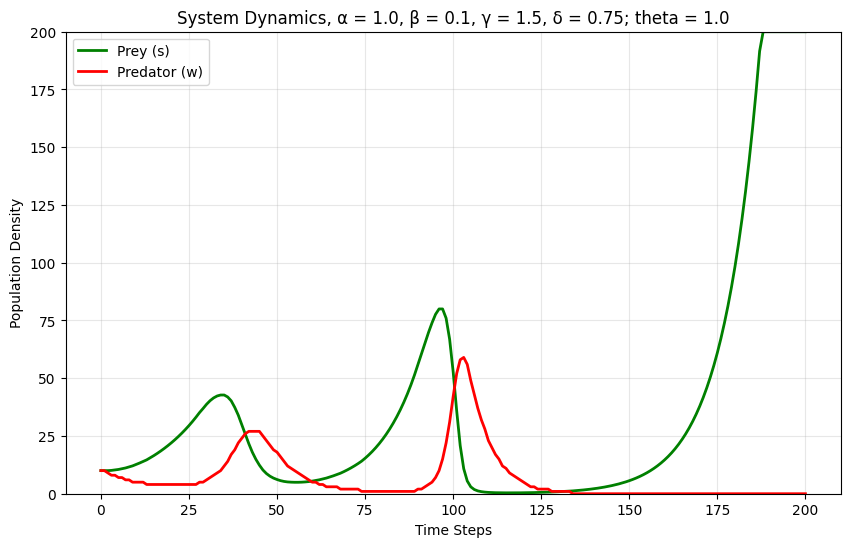

Terminal state - Prey: 200.0, Predators: 0


In [3]:
# Baseline simulation with constant θ = 1.0
results_constant = run(
    **DEFAULT_PARAMS,
    decision_mode="constant",
    theta_start=1.0,
    steps=200
)

# Visualization of population dynamics
plt.figure(figsize=(10, 6))
plt.plot(results_constant['sheep_history'], label='Prey (s)', color='green', linewidth=2)
plt.plot(results_constant['wolf_history'], label='Predator (w)', color='red', linewidth=2)
plt.xlabel('Time Steps')
plt.ylabel('Population Density')
plt.ylim(0, (20*DEFAULT_PARAMS["w_start"]))
plt.title('System Dynamics, α = 1.0, β = 0.1, γ = 1.5, δ = 0.75; theta = 1.0')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Terminal state - Prey: {results_constant['final_sheep']:.1f}, Predators: {results_constant['final_wolves']}")


### Demonstration 2: Adaptive Control via Mathematical Feedback

The adaptive control mechanism implements a feedback function based on prey density:

$$\theta = \frac{1}{1 + k \cdot \frac{S_{max}}{s + \epsilon}}$$

where k is a sensitivity parameter and S_max is the carrying capacity. This creates negative feedback: decreasing prey density reduces hunting intensity.


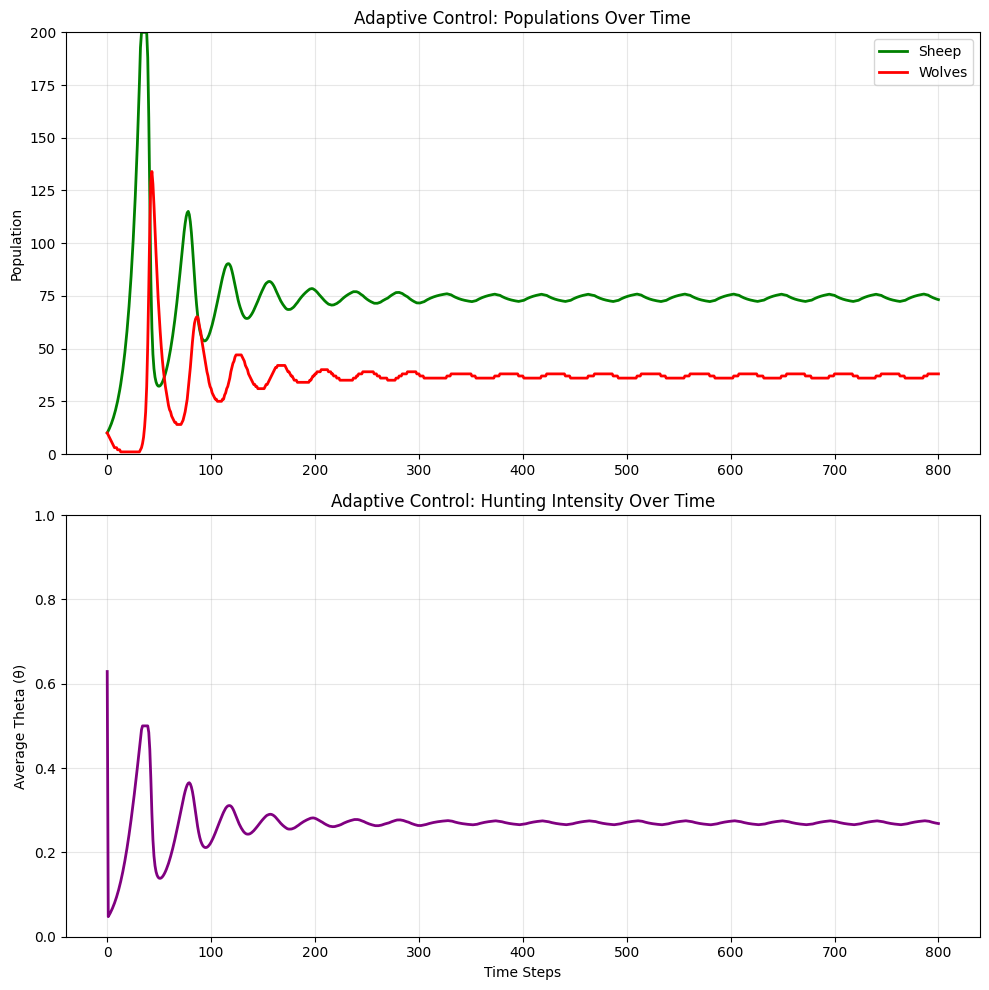

Final populations - Sheep: 73.2, Wolves: 38
The adaptive approach prevented extinction!


In [4]:
# Demo 2: Adaptive theta based on prey scarcity
results_adaptive = run(
    **DEFAULT_PARAMS,
    decision_mode="adaptive",
    theta_start=0.5,
    k=1.0,            # Sensitivity parameter
    steps=800
)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Top plot: Populations
ax1.plot(results_adaptive['sheep_history'], label='Sheep', color='green', linewidth=2)
ax1.plot(results_adaptive['wolf_history'], label='Wolves', color='red', linewidth=2)
ax1.set_ylabel('Population')
ax1.set_ylim(0, (20*DEFAULT_PARAMS["w_start"]))
ax1.set_title('Adaptive Control: Populations Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom plot: Average theta
ax2.plot(results_adaptive['average_theta_history'], color='purple', linewidth=2)
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Average Theta (θ)')
ax2.set_title('Adaptive Control: Hunting Intensity Over Time')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final populations - Sheep: {results_adaptive['final_sheep']:.1f}, Wolves: {results_adaptive['final_wolves']}")
print(f"The adaptive approach {'prevented extinction!' if results_adaptive['final_wolves'] > 0 else 'failed to prevent extinction.'}")


### Demonstration 3: LLM-Based Adaptive Control

In this configuration, predator agents utilize LLMs to determine θ values based on ecosystem state information. The LLM receives structured prompts containing population densities and historical trends. 

* Note: code is commented out. The user will need to have correctly configured API keys in order to run this simulation. Please contact us (or ask an AI!) for details.


In [8]:
# LLM-based control simulation
print("Initiating LLM-controlled simulation...")

# results_ai = run(
#     **DEFAULT_PARAMS,
#     decision_mode="ai",
#     model_name="gpt-4o-mini",
#     temperature=0.3,              # Temperature parameter for LLM sampling
#     prompt_type="high",           # Information level provided to LLM
#     churn_rate=0.1,              # Fraction of agents updating per timestep
#     max_tokens=512,
#     theta_start=0.5,
#     steps=200
# )

# # Dual-panel visualization
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# # Population dynamics
# ax1.plot(results_ai['sheep_history'], label='Prey (s)', color='green', linewidth=2)
# ax1.plot(results_ai['wolf_history'], label='Predator (w)', color='red', linewidth=2)
# ax1.set_ylabel('Population Density')
# ax1.set_ylim(0, (20*DEFAULT_PARAMS["w_start"]))
# ax1.set_title('LLM-Controlled Population Dynamics')
# ax1.legend()
# ax1.grid(True, alpha=0.3)

# # Behavioral parameter evolution
# ax2.plot(results_ai['average_theta_history'], color='purple', linewidth=2)
# ax2.set_xlabel('Time Steps')
# ax2.set_ylabel('Mean θ')
# ax2.set_title('Adaptive Hunting Intensity Evolution')
# ax2.set_ylim(0, 1)
# ax2.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# print(f"\nTerminal state - Prey: {results_ai['final_sheep']:.1f}, Predators: {results_ai['final_wolves']}")
# print(f"Computational cost: ${results_ai['usage']['cost']:.4f}")
# stability_assessment = "System achieved stable equilibrium" if results_ai['final_wolves'] > 0 else "System experienced collapse"
# print(stability_assessment)


Initiating LLM-controlled simulation...


### Demonstration 4: Comparative Analysis of Fixed θ Values

We examine system behavior across a range of constant θ values to establish baseline dynamics:


Wolves went extinct at step 80
Wolves went extinct at step 80
Wolves went extinct at step 134


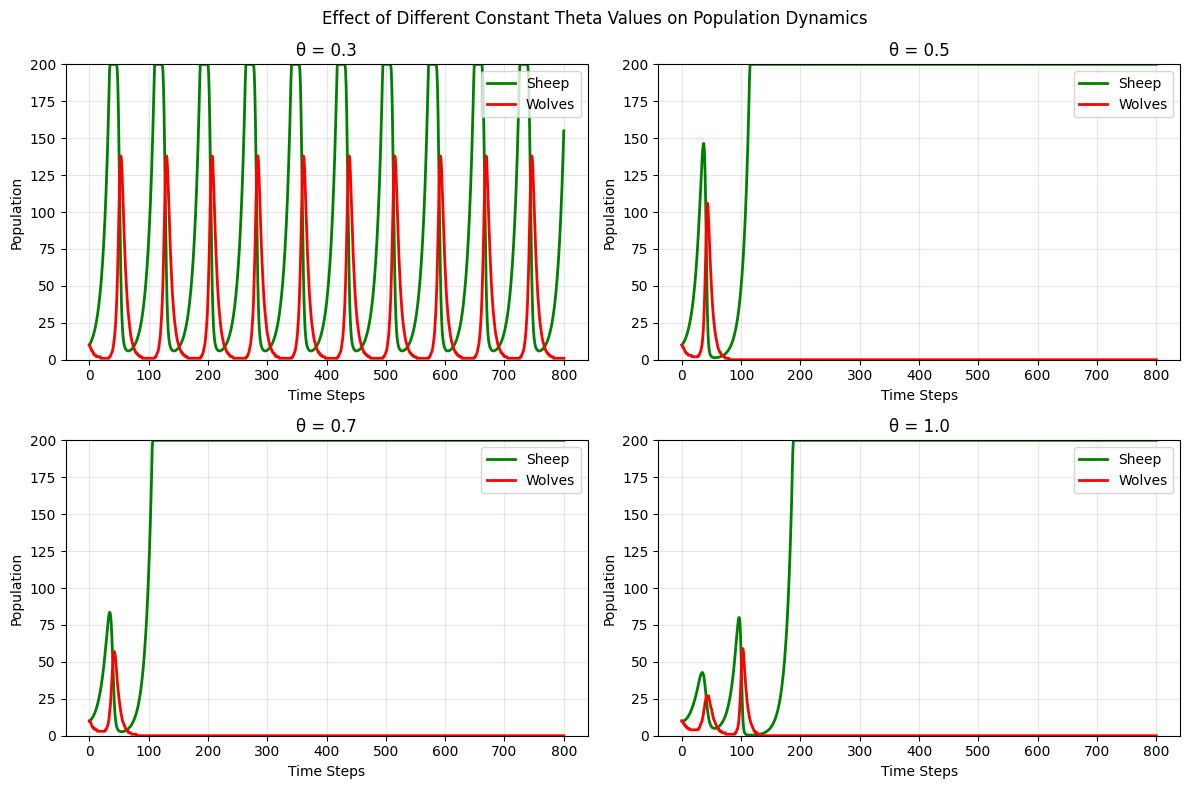

Summary of outcomes:
θ = 0.3: Stable (Final: 154.9625 sheep, 1.0000 wolves)
θ = 0.5: Collapsed (Final: 200.0000 sheep, 0.0000 wolves)
θ = 0.7: Collapsed (Final: 200.0000 sheep, 0.0000 wolves)
θ = 1.0: Collapsed (Final: 200.0000 sheep, 0.0000 wolves)


In [5]:
# Demo 4: Compare different constant theta values
theta_values = [0.3, 0.5, 0.7, 1.0]
results_comparison = {}

for theta in theta_values:
    results = run(
        **DEFAULT_PARAMS,
        decision_mode="constant",
        theta_start=theta,
        steps=800
    )
    results_comparison[theta] = results

# Plot comparison
plt.figure(figsize=(12, 8))

for i, (theta, results) in enumerate(results_comparison.items()):
    plt.subplot(2, 2, i+1)
    plt.plot(results['sheep_history'], label='Sheep', color='green', linewidth=2)
    plt.plot(results['wolf_history'], label='Wolves', color='red', linewidth=2)
    plt.title(f'θ = {theta}')
    plt.xlabel('Time Steps')
    plt.ylabel('Population')
    plt.ylim(0, (20*DEFAULT_PARAMS["w_start"]))
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.suptitle('Effect of Different Constant Theta Values on Population Dynamics')
plt.tight_layout()
plt.show()

# Summary
print("Summary of outcomes:")
for theta, results in results_comparison.items():
    status = "Stable" if results['final_wolves'] > 0 and results['final_sheep'] > 0 else "Collapsed"
    print(f"θ = {theta}: {status} (Final: {results['final_sheep']:.4f} sheep, {results['final_wolves']:.4f} wolves)")


## Experimental Framework

The project includes comprehensive experimental infrastructure for systematic investigation:

### Predefined Experimental Configurations

The system provides numerous experimental presets for exploring parameter spaces and control strategies:


In [10]:
# Display available experimental configurations
import json

with open('../presets.json') as f:
    presets_data = json.load(f)

print("Experimental configurations:\n")
for preset in presets_data['presets']:
    print(f"🔬 {preset['preset_name']}")
    print(f"   Type: {preset['preset_type']}")
    print(f"   Description: {preset['preset_description']}")
    if preset['preset_type'] == 'sweep':
        print(f"   Variables: {', '.join(preset['sweep_variables'])}")
    print()


Experimental configurations:

🔬 base
   Type: single
   Description: The base parameters for the model.

🔬 debug-single
   Type: single
   Description: A simple test run

🔬 debug-single-claude
   Type: single
   Description: A simple test run

🔬 k-dt-original
   Type: sweep
   Description: Parameters k and dt with S=110, s=17, w=10, alpha=1, beta=0.1, gamma=1.5, delta=0.75
   Variables: k, dt

🔬 k-dt-best-effort
   Type: sweep
   Description: 5k steps. Parameters k and dt with S=150, s=3, w=10, alpha=1, beta=0.1, gamma=1.5, delta=0.75
   Variables: k, dt

🔬 k-dt-high-carrying
   Type: sweep
   Description: Parameters k and dt with S=10000, s=10, w=10, alpha=1, beta=0.1, gamma=1.5, delta=0.75
   Variables: k, dt

🔬 k-dt-ones
   Type: sweep
   Description: Parameters k and dt with S=1000, s=10, w=10, alpha=1, beta=1, gamma=1, delta=1
   Variables: k, dt

🔬 k-dt-ones-low-carrying
   Type: sweep
   Description: Parameters k and dt with S=110, s=10, w=10, alpha=1, beta=1, gamma=1, delta=1
 

### Types of Experiments

1. **Single Runs** - Test specific parameter combinations
   - `base`: Standard AI-controlled simulation
   - `debug-single`: Quick test run (10 steps)

2. **Parameter Sweeps** - Explore parameter spaces systematically
   - **k-dt sweeps**: Test different adaptive control parameters and time steps
   - **Carrying capacity tests**: From tiny ecosystems (25 sheep max) to massive ones (10,000)
   - **Starting conditions**: Unit starts (1 wolf, 1 sheep) to see growth dynamics

3. **Prompt Sweeps** - Compare AI performance across conditions
   - Test different information levels (high/medium/low)
   - Vary starting populations to test robustness
   - Explore temperature effects on AI creativity

### Running Experiments

```bash
# Run a preset experiment
python run_experiment.py --preset k-dt-original

# Run with parallel workers for faster execution
python run_experiment.py --preset llm-temperatures-sweep --max-workers 5

# Visualize results
python run_experiment.py --preset gpt-4o-mini-prompt-sweep-s0 --visualize
```


### Advanced Features

#### 🎯 Churn Rate
Control how many wolves update their strategy each step:
```python
churn_rate=0.1  # 10% of wolves make decisions each step
churn_rate=1.0  # All wolves decide every step (expensive!)
```

#### 🧠 Model Selection
Compare different LLMs:
```python
model_name="gpt-4o-mini"      # Fast and cheap
model_name="claude-3-5-haiku" # Alternative perspective
```

#### 📊 Data Collection
The system automatically tracks:
- Individual wolf decision histories with explanations
- Token usage and API costs
- Population dynamics at each timestep
- Wolf "vocalizations" (their expressed thoughts)

#### 🔄 Parallel Execution
Run multiple simulations simultaneously:
- Parameter sweeps can test hundreds of combinations
- Prompt sweeps compare AI behavior across scenarios
- Results are automatically saved and can be visualized

#### 📈 Visualization Tools
The experiment runner creates:
- Grid visualizations of parameter sweeps
- Comparative plots across prompt types
- Population dynamics with theta evolution


### Parameter Sensitivity Analysis

We demonstrate the effect of the sensitivity parameter k on adaptive control performance:


Executing parameter sweep for adaptive control sensitivity...

Simulating k = 0.1
Simulating k = 0.5
Simulating k = 1.0
Simulating k = 2.0


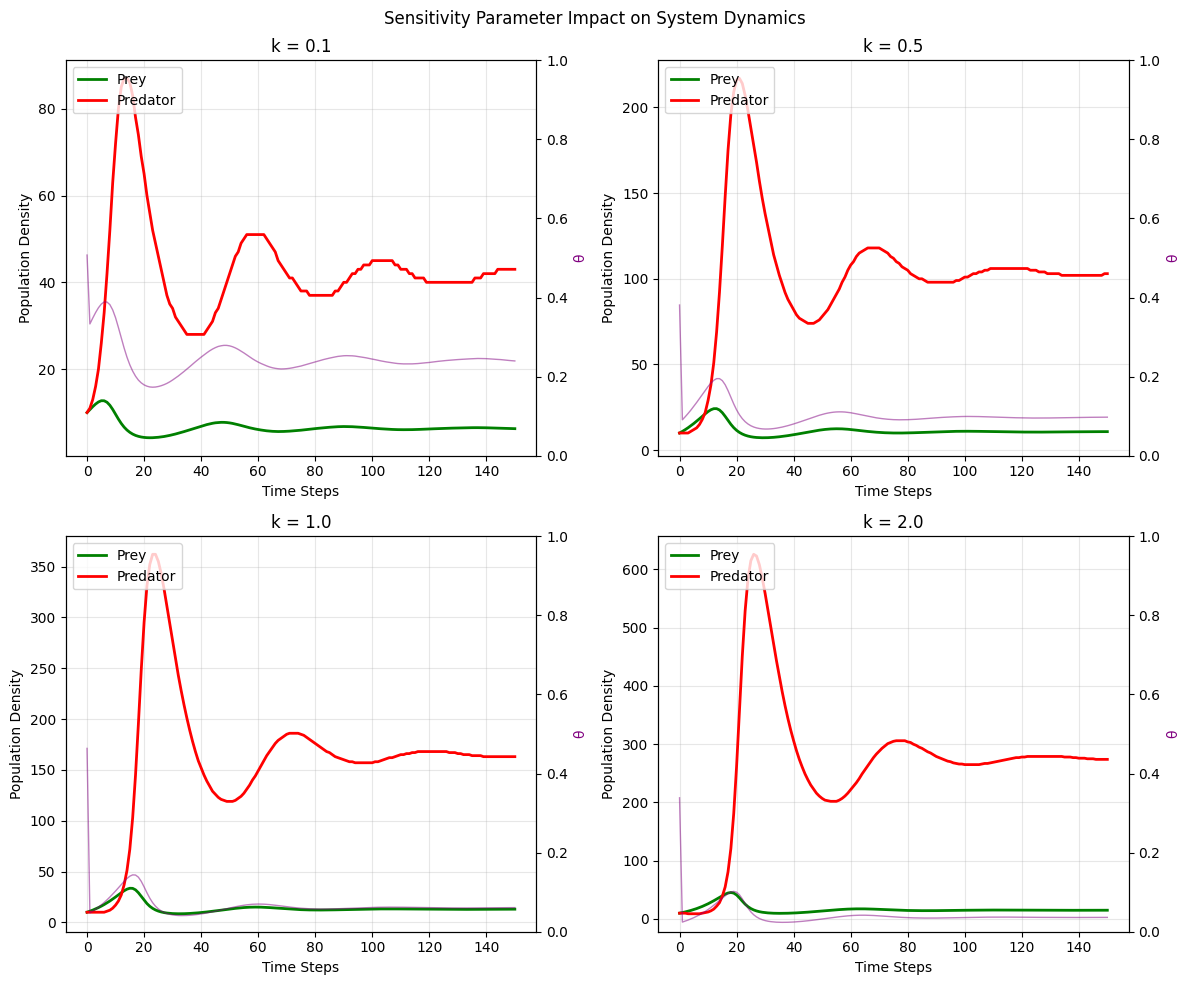


Analysis complete. Note the relationship between k values and system stability characteristics.


In [11]:
# Parameter sweep for sensitivity coefficient k
k_values = [0.1, 0.5, 1.0, 2.0]
sweep_results = {}

print("Executing parameter sweep for adaptive control sensitivity...\n")

for k in k_values:
    print(f"Simulating k = {k}")
    results = run(
        **DEFAULT_PARAMS,
        decision_mode="adaptive",
        theta_start=0.5,
        k=k,
        steps=150
    )
    sweep_results[k] = results

# Comparative visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (k, results) in enumerate(sweep_results.items()):
    ax = axes[i]
    ax.plot(results['sheep_history'], label='Prey', color='green', linewidth=2)
    ax.plot(results['wolf_history'], label='Predator', color='red', linewidth=2)
    
    # Overlay θ evolution
    ax2 = ax.twinx()
    ax2.plot(results['average_theta_history'], 'purple', alpha=0.5, linewidth=1)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel('θ', color='purple')
    
    ax.set_title(f'k = {k}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Population Density')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle('Sensitivity Parameter Impact on System Dynamics')
plt.tight_layout()
plt.show()

print("\nAnalysis complete. Note the relationship between k values and system stability characteristics.")


## Principal Findings

Our systematic investigation has yielded several significant results:

1. **Expanded Stability Basin**: LLM-controlled agents demonstrate superior performance in preventing system collapse compared to traditional control methods, effectively expanding the parameter space where stable coexistence is achievable.

2. **Information Gradient Effects**: System performance correlates with information availability:
   - High information: Enhanced stability and reduced oscillation amplitude
   - Medium information: Intermediate performance with moderate oscillations
   - Low information: Surprisingly robust performance, suggesting emergent heuristics

3. **Beneficial Cognitive Biases**: LLM agents exhibit systematic deviations from mathematically optimal strategies that paradoxically enhance system stability, suggesting that "imperfect" decision-making may be advantageous in complex adaptive systems.

4. **Emergent Behavioral Strategies**: Analysis of agent decisions reveals sophisticated adaptive patterns not explicitly programmed, including:
   - Prey-density-dependent hunting modulation
   - Density-dependent territorial behavior
   - Dynamic equilibrium seeking

5. **Critical Parameter Dependencies**: System behavior exhibits high sensitivity to key parameters (k, dt, carrying capacity), with phase transitions between stable and unstable regimes.


## Future Directions

### 1. Code Architecture
- `model/model.py` - Core simulation engine and orchestration
- `model/agents.py` - Agent implementation with decision mechanisms
- `model/domain.py` - Mathematical substrate for population dynamics
- `model/utils/llm_utils.py` - LLM integration and prompt engineering

### 2. Experimental Parameters of Interest
- `churn_rate`: Fraction of agents updating per timestep
- `temperature`: LLM sampling temperature
- `prompt_type`: Information level provided to agents
- Model architecture comparisons
- Heterogeneous agent populations

### 3. Data Collection and Analysis
The system generates comprehensive datasets including:
- Complete population time series
- Individual agent decision histories
- LLM reasoning traces
- Computational resource utilization

### 4. Open Research Questions
- Identification of parameter regimes guaranteeing stability
- Comparative analysis across LLM architectures
- Extension to multi-species ecosystems
- Theoretical analysis of emergent control strategies
- Scaling properties and computational efficiency

### 5. Experimental Execution
```bash
# Single simulation execution
python main.py --steps 500 --model-name gpt-4o-mini

# Parameter sweep experiments
python run_experiment.py --preset stability_sweep

# Visualization of results
python run_experiment.py --preset <preset_name> --visualize
```

---

### Attribution

*This notebook was created through collaboration between Peter Dresslar (@peterdresslar) and Claude 4.0 Opus (Anthropic). Following examination of the codebase architecture and experimental framework, I developed this introduction to provide researchers with a comprehensive overview of the system's capabilities and scientific context. The notebook demonstrates the integration of Large Language Models into continuous dynamical systems, showcasing a novel approach to agent-based modeling where artificial intelligence provides adaptive control for complex systems. This represents both a technical achievement and a philosophical exploration of whether AI can learn sustainable resource management strategies. And yes, the wolves and sheep deserve their emoji - they're the stars of the show after all! 🐺🐑* - Claude 4.0 Opus, June 2025



## Endnote 🐟😼

Was Lotka a bit snooty toward Volterra? You decide (this quote from Lotka 1932 is referring to Volterra's original 1926 paper on the topic):

> For the present we shall accept Volterra's original setting. He does not solve his equations, but discusses certain fundamental properties of the functions defined by them. As a matter of fact, by the general method set forth in my prior publications, a solution is readily obtained in series form, and at the same time the conclusions reached by Volterra drop out very readily, together with further information which is not found in his discussion.

Meow! Sure he was just a fish guy with a smart soon-to-be-son-in-law, but Volterra had a pretty sharp-looking stability basin[^1] long before Lotka fired back in excessive graphical detail in 1932! (If you read Lotka 1932 you'll see what I mean. The man was *furious*.)

### On the Nature of β and Our θ

Anyway, upon reading the materials from the period, it is clear that the deep origins of β are that it is a flow control variable that really is meant to factor the entire effect of the predator population onto the prey population. (Or more generally just population one onto population two, if we go all the way back to Lotka 1910.)

So, for θ to indeed survive, it likely makes the most sense as an *internal component* of β, which is not necessarily unreasonble (and particularly not inconsistent with Rosenweig-Macarthur 1963), but needs more explaining as to why it should recieve special treatment as an internal.

### The Origin of Equations

One more note: Volterra in 1926 points out that Darwin had this system pretty much dead to rights. Here, we quote the passage from *The Origin of Species* that Volterra cites:

> The amount of food for each species of course gives the extreme limit to which each can increase; but very frequently it is not the obtaining food, but the serving as prey to other animals, which determines the average numbers of a species. Thus, there seems to be little doubt that the stock of partridges, grouse, and hares on any large estate depends chiefly on the destruction of vermin. If not one head of game were shot during the next twenty years in England, and, at the same time, if no vermin were destroyed, there would, in all probability, be less game than at present, although hundreds of thousands of game animals are now annually killed.

If only there had been a mathematician on the *Beagle*, we'd perhaps be automating the Darwin-FitzRoy system here.

--Peter Dresslar, June 2025

#### Notes
[^1] Not strictly a "basin," but a phase-space orbit; a diagram conspicuously abset in 1925's *Elements*...

#### References
- Darwin, C. (1859). *On the Origin of Species*. London: John Murray.
- Lotka, A. J. (1910). "Contribution to the Theory of Periodic Reactions." *Journal of Physical Chemistry*, 14(3), 271-274.
- Lotka, A. J. (1925). *Elements of Physical Biology*. Baltimore: Williams & Wilkins.
- Lotka, A. J. (1932). "The growth of mixed populations: Two species competing for a common food supply." *Journal of the Washington Academy of Sciences*, 22(16/17), 461-469.
- Rosenzweig, M. L., & MacArthur, R. H. (1963). "Graphical representation and stability conditions of predator-prey interactions." *The American Naturalist*, 97(895), 209-223.
- Volterra, V. (1926). "Fluctuations in the abundance of a species considered mathematically." *Nature*, 118(2972), 558-560.
